In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.utils import CustomLandmarks
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

import constants
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
        
vhr.plot.VisualizeParams.renderer = 'vscode' 

In [2]:
landmarks = CustomLandmarks()
all_landmarks = list(landmarks.get_all_landmarks().keys())

# Defining the color palette
palette = sns.color_palette("Set3", n_colors=len(all_landmarks))
palette = dict(zip(all_landmarks, palette))

# Functions

In [16]:
def get_data_each_landmark(df, metric, dataset_name):
    ### Get data
    if type(df['landmarks'].iloc[0]) != str:
        df['landmarks'] = df['landmarks'].apply(lambda x: x[0])
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
        df['person'] = df.videoFilename.apply(lambda x: x.split('_')[0])
    elif dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
        df['person'] = df.videoFilename.apply(lambda x: x.split('_')[0])
    else:
        print("Video and person format not defined for ", dataset_name)

    return df

def plot_boxplot_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    grouped = df[['landmarks', metric]].groupby('landmarks').median().sort_values(by=metric)

    if ax is None:
        ax = plt.gca()
    box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, palette=palette, hue='landmarks', legend='brief', ax=ax)
    box.legend_.remove()
    labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
    box.set_xticks(range(len(labels)))
    box.set_xticklabels(labels,rotation=90, fontsize=7)
    box.set_title(f"Boxplot of average MAE for individual landmarks ({dataset_name.upper()})")

    return grouped, box

def plot_histogram_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    rankings = df.groupby('videoIdx')[metric].rank(ascending=True).groupby(df['landmarks']).mean().sort_values().reset_index()
    
    if ax is None:
        ax = plt.gca()
    bar = sns.barplot(x=metric, y='landmarks', data=rankings, palette=palette, hue='landmarks', ax=ax)
    labels = [item.get_text().replace('_', ' ')  for item in ax.get_yticklabels()]
    bar.set_yticks(range(len(labels)))
    bar.set_yticklabels(labels, fontsize=6)
    bar.set_title(f"Average rankings of the MAE values for individual landmarks ({dataset_name.upper()})")

    return rankings, bar

def plot_each_landmark(df, metric, dataset_name, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    df = get_data_each_landmark(df, metric, dataset_name)
    grouped, box = plot_boxplot_each_landmark(df, metric, dataset_name, axs[0])
    rankings, bar = plot_histogram_each_landmark(df, metric, dataset_name, axs[1])

    return df, grouped, rankings, box, bar

In [17]:
def get_palette(df, hue='landmarks_id'):
    # Defining the color palette
    palette = sns.color_palette("Set3", n_colors=len(df[hue].unique()))
    palette = dict(zip(df[hue].unique(), palette))
    return palette

def get_handle_labels(df, axes, redundant=False):
    """
        From landmarks_ids (0,1,...) to landmarks names (forehead, nose, ...)
    """
    landamarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
    if type(landamarks_mapping['landmarks'][0]) == tuple:
        landmarks_names = [', '.join([name.replace('_', ' ') for name in names]) for names in landamarks_mapping['landmarks'].values]
    else:
        landmarks_names = [name.replace('_', ' ') for name in landamarks_mapping['landmarks'].values]
    landamarks_mapping = dict(zip(landamarks_mapping['landmarks_id'].values, landmarks_names))

    if redundant:
        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles = [None] * len(df['landmarks_id'].unique())
        labels = [None] * len(df['landmarks_id'].unique())
        for (handle_label) in handles_labels:
            for i,(h,l) in enumerate(zip(*handle_label)):
                if  handles[int(l)] is None:
                    handles[int(l)] = h
                    labels[int(l)] = l+'. '+str(landamarks_mapping[int(l)])
    else:
        handles, labels = axes.get_legend_handles_labels()
        for i,(h,l) in enumerate(zip(handles, labels)):
            if i == 0:
                labels[i] = 'Landmarks'
            if l.isdigit(): # check the label is a landmarks_id digit (not a label)
                labels[i] = l+'. '+str(landamarks_mapping[int(l)])
            if i > len(df['landmarks_id'].unique()):
                break
                
    return handles, labels

def get_rankings_roi(df, dataset_name, metric='MAE'):
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
    if dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
    df['score'] = df.groupby(['video','landmarks']).MAE.transform('mean')
    df = df.reset_index(drop=True)

    rankings = df.sort_values(['video','score']).drop_duplicates(['video','score']).groupby(['video']).head(5)
    rankings['landmarks_id'] = rankings['landmarks'].astype('category').cat.codes
    rankings = rankings[['video', 'videoIdx', 'landmarks','landmarks_id','MAE', 'RMSE', 'PCC','score']]\
                        .reset_index(drop=True)

    return df, rankings

def plot_bar_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):

    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    palette = get_palette(rankings, 'landmarks_id')
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        df_video = rankings[rankings.video==video]
        bar = sns.barplot(x='landmarks_id', y='score', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        for container in ax.containers:
            bar.bar_label(container, fmt='%.1f', padding=-15)
        bar.set(xlabel=None, ylabel=None)
        if i < len(df.video.unique()) - 2:
            bar.set(xlabel=None, ylabel=None, xticks=[])
        bar.legend_.remove()
        bar.set_title(video)
    fig.supxlabel("Landmarks ID")
    fig.supylabel("Average MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name}))")
    handles, labels = get_handle_labels(rankings, fig.axes, redundant=True)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    return fig, axs

def add_median_labels(ax, medians, fmt=".1f") -> None:
    # vertical_offset = df_video['MAE'].median() * 0.03 # offset from median for display
    lines = ax.get_lines()
    for i,xtick in enumerate(ax.get_xticks()):
        text = ax.text(xtick, medians.iloc[xtick], medians.iloc[xtick], color='white',
                        horizontalalignment='center', verticalalignment='center', fontsize=9) # color='b',weight='semibold' size='x-small'
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=lines[i].get_color()),
            path_effects.Normal(),
        ])
        # ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
        #         horizontalalignment='center', size='x-small') # color='b',weight='semibold'

def plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):
    
    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
    palette = get_palette(df,'landmarks_id')
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        landmarks_ids = rankings[rankings.video==video]['landmarks_id']
        df_video = df[df.video==video].query('landmarks_id in @landmarks_ids')
        ax = sns.boxplot(x='landmarks_id', y='MAE', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        ax.set(xlabel=None, ylabel=None)
        ax.legend_.remove()
        ax.set_title(video)

        medians = df_video.groupby(['landmarks_id'])['MAE'].median().round(2)
        add_median_labels(ax, medians)
        if i < len(df.video.unique()) - 2:
            ax.set(xlabel=None, ylabel=None, xticks=[])
    fig.supxlabel("Landmarks ID")
    fig.supylabel("MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name})")
    handles, labels = get_handle_labels(rankings, fig.axes, redundant=True)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    return fig, axs

def plot_bubble_roi(df, metric, dataset_name, roi, fig, axs, title=None, size=[1200,400]):

    df = df.copy()
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
    if dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
    df['ldmk_time'] = df.groupby('landmarks')['TIME_REQUIREMENT'].transform('sum')
    df['ldmk_MAE'] = df.groupby('landmarks')['MAE'].transform('mean')
    df['ldmk_size'] = df['landmarks'].apply(lambda x: len(x))
    if len(df.loc[0,'dataset'].split('_'))> 3: # testing combination of ROIs
        df['landmarks'] = df['dataset'].apply(lambda x: ', '.join((x.split('_')[2:])))
    else: # testion single ROI and multiple landmarks
        df['landmarks'] = df.landmarks.apply(lambda x: ', '.join(x).replace('_',' ').replace('(','').replace(')',''))    
    df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
    df['landmarks'] = df['landmarks_id'].astype('str') + ': ' + df['landmarks'] 
    df = df.sort_values(by='landmarks_id').reset_index(drop=True)
    
    fig = px.scatter(df, x="ldmk_time", y="ldmk_MAE", color="landmarks", size='ldmk_size', hover_data=['landmarks'], text='landmarks_id',
                    template='none', color_discrete_sequence=px.colors.qualitative.Set2, width=size[0], height=size[1],
                    labels={'ldmk_time':'Time requirement (s)', 'ldmk_MAE':'MAE (bpm)', 'landmarks':'Landmarks', 'ldmk_size':'Number of landmarks'},
                    title=f"MAE vs Time requirement for each landmark ({dataset_name.upper()} {roi})",) 
    fig.update_traces(textposition='middle center', textfont_size=12, textfont_family='Courier New') 
    fig.update_xaxes(showline=True, linecolor='black', mirror=True) # linewidth=2, 
    fig.update_yaxes(showline=True, linecolor='black', mirror=True)
    if title is not None:
        fig.update_layout(title_text=title)
    return df, fig, axs

# LGI-PPGI

In [4]:
# -- LOAD A DATASET

dataset_name = 'LGI_PPGI'    
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
wsize = 8        # seconds of video processed (with overlapping) for each estimate 
fps = vhr.extraction.get_fps(dataset.getSigFilename(0))


# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

0 D:/datasets_rppg/LGI_PPGI\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/LGI_PPGI\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/LGI_PPGI\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/LGI_PPGI\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/LGI_PPGI\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/LGI_PPGI\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/LGI_PPGI\angelo\angelo_rotation\cv_camera_sensor_stream_handler.avi
7 D:/datasets_rppg/LGI_PPGI\angelo\angelo_talk\cv_camera_sensor_stream_handler.avi
8 D:/datasets_rppg/LGI_PPGI\cpi\cpi_gym\cv_camera_sensor_stream_handler.avi
9 D:/datasets_rppg/LGI_PPGI\cpi\cpi_resting\cv_camera_sensor_stream_handler.avi
10 D:/datasets_rppg/LGI_PPGI\cpi\cpi_rotation\cv_camera_sensor_stream_handler.avi
11 D:/datasets_rppg/LGI_PPGI\cpi\cpi_talk\cv_camera_sensor_stream_handler.avi
12 D:/datasets_rppg/LGI_

## Boxplot by landmark

Reding  ../results/test_landmarks/h5/LGI_PPGI/LGI_PPGI_each_landmark.h5


NameError: name 'plot_each_landmark' is not defined

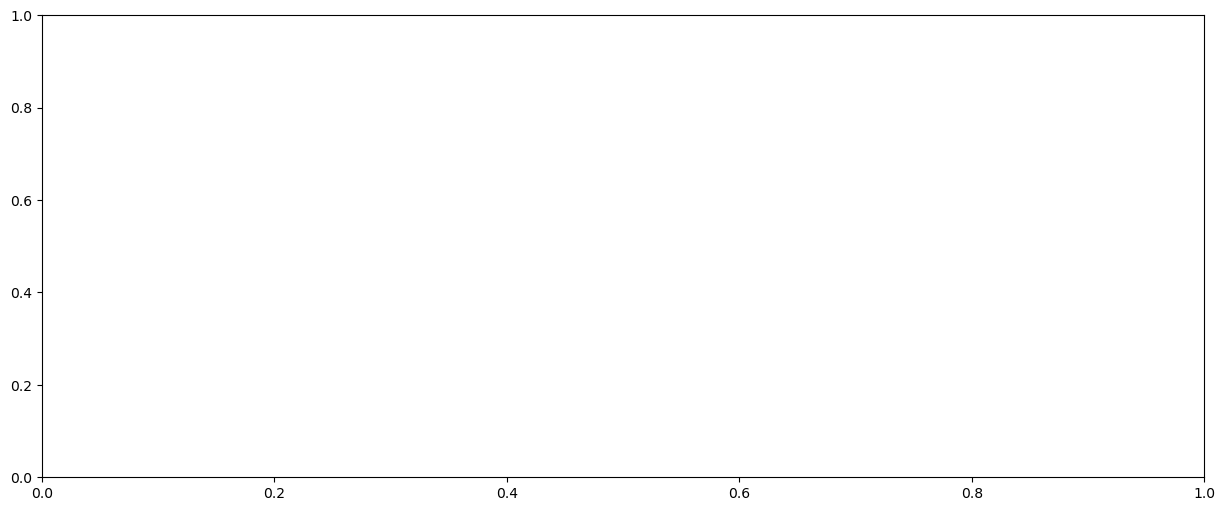

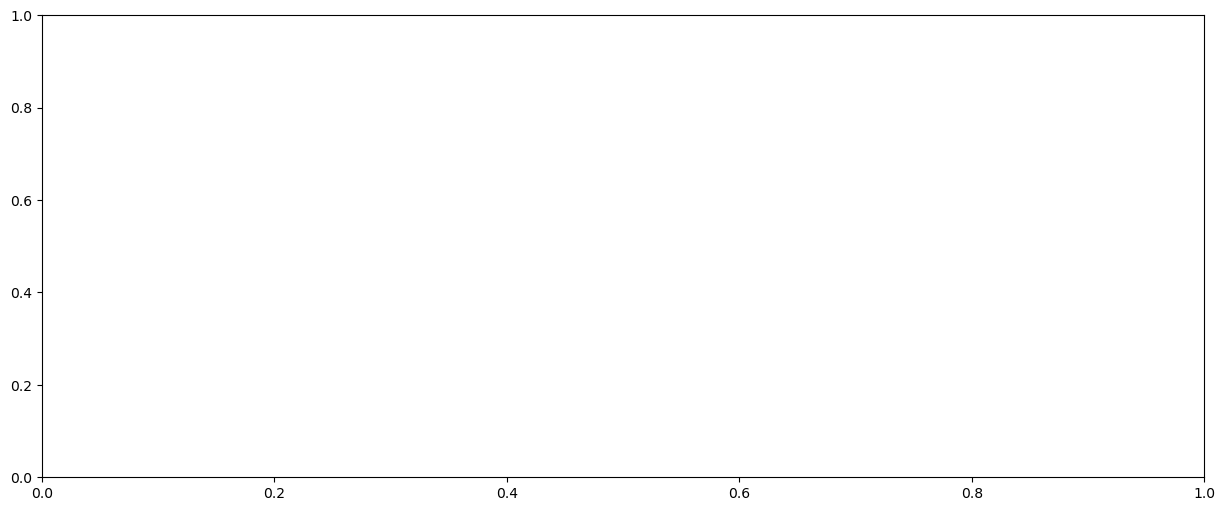

In [5]:
path_results = f"../results/test_landmarks/h5/{dataset_name}/" # general path for cfg# general path for data
filenameH5 = path_results + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)

df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(15,6))
_, ax2 = plt.subplots(1,1, figsize=(15,6))
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

# df = df.query('person != "felix"')
# print("I am taking out felix videos because fuck them")
# df = df.query('video != "gym"')
# print("I am taking out gym videos because fuck them")

In [ ]:
# Worst performing video on each video setting
df.query("landmarks == 'glabella'").query('method == "CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,video,person
252,CHROM,lgi_ppgi_forehead,20,harun_gym,[42.80714367317885],32.397053,[-0.07442693095141334],[-0.03090422630544887],[-5.070012055500783],[107.54296875],"[0.732421875, 2.197265625, 5.4931640625, 26.73...",[9607.6298828125],"[99.5, 99.0, 98.5, 100.0, 102.5, 105.0, 105.5,...","[54.931640625, 55.2978515625, 57.12890625, 78....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",150.571444,glabella,gym,harun
228,CHROM,lgi_ppgi_forehead,11,cpi_talk,[20.23307701007192],17.823664,[0.18742090091012117],[0.05505452028612498],[-3.9550230718167447],[37.892578125],"[1.8310546875, 0.732421875, 2.9296875, 3.29589...",[1212.0576171875],"[71.0, 72.0, 73.5, 76.5, 80.5, 85.5, 89.5, 90....","[54.931640625, 55.2978515625, 89.35546875, 87....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",40.808290,glabella,talk,cpi
258,CHROM,lgi_ppgi_forehead,22,harun_rotation,[16.010701405515054],10.690833,[0.24877433478585753],[0.06151786089665611],[-1.1344514451255756],[35.2236328125],"[0.3662109375, 0.732421875, 1.46484375, 0.7324...",[587.7197265625],"[87.5, 88.5, 90.5, 91.5, 90.5, 88.0, 85.0, 82....","[90.8203125, 89.35546875, 87.158203125, 83.496...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",35.249027,glabella,rotation,harun
243,CHROM,lgi_ppgi_forehead,17,felix_resting,[5.566763594865538],5.109918,[0.05593953167019054],[0.006516580670828737],[14.234547471952817],[11.08984375],"[0.3662109375, 0.0, 0.0, 0.0, 0.732421875, 0.0...",[368.0263671875],"[56.0, 55.0, 53.5, 52.0, 51.5, 51.5, 51.5, 51....","[47.2412109375, 47.607421875, 47.607421875, 47...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",34.638288,glabella,resting,felix


## Individual landmarks by video setting

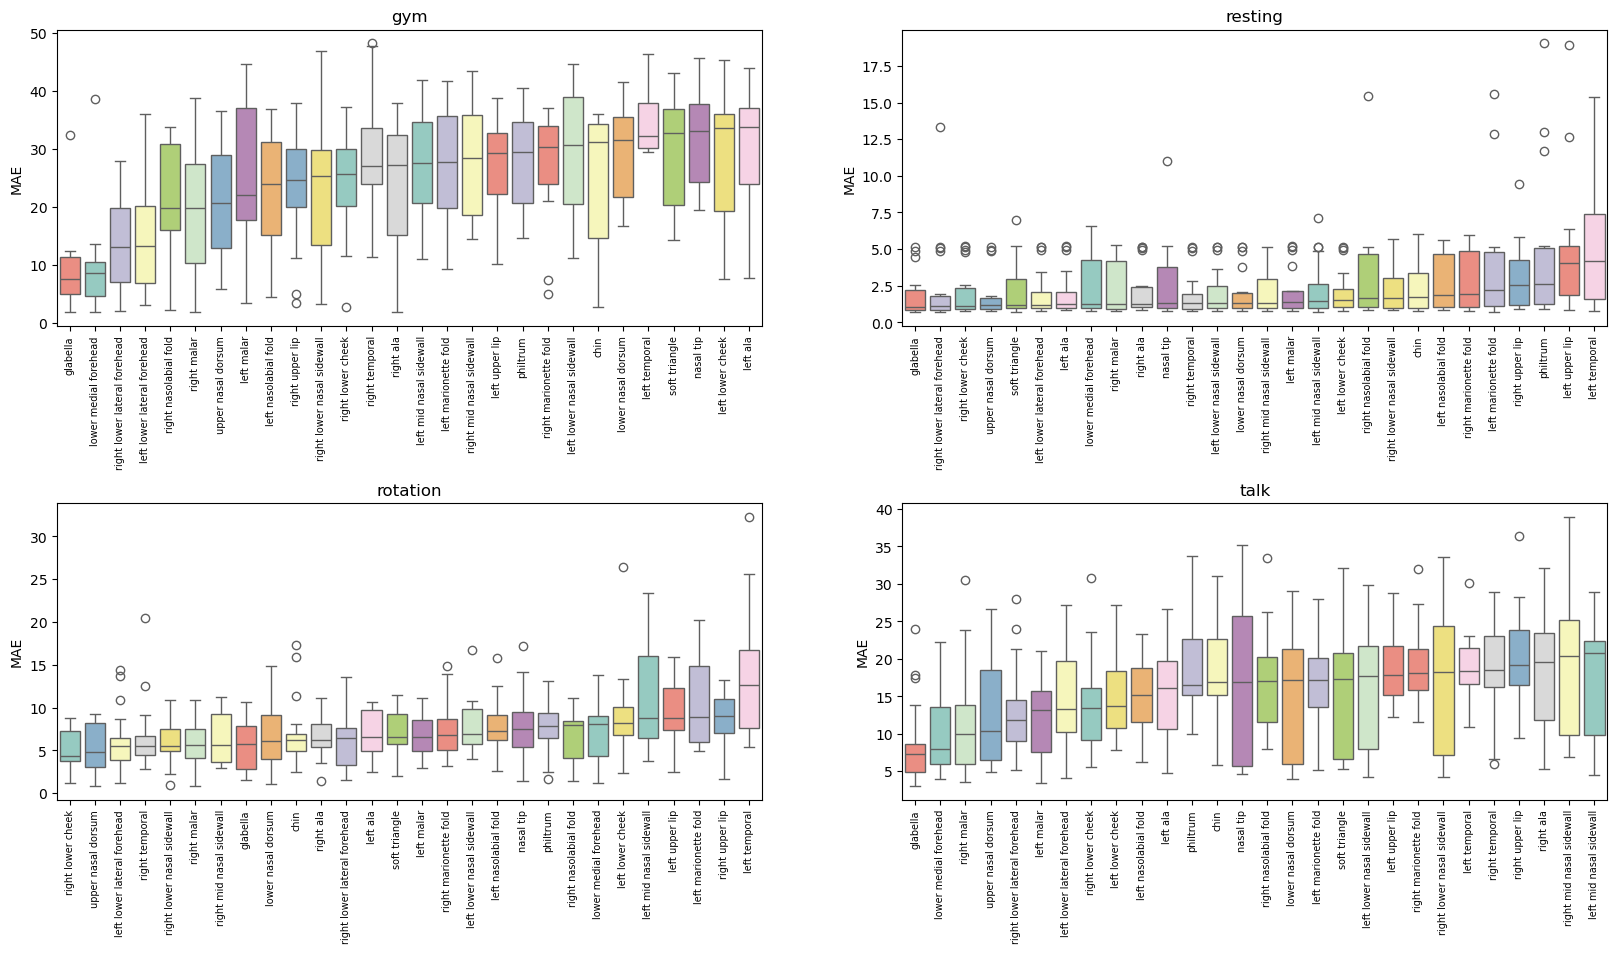

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

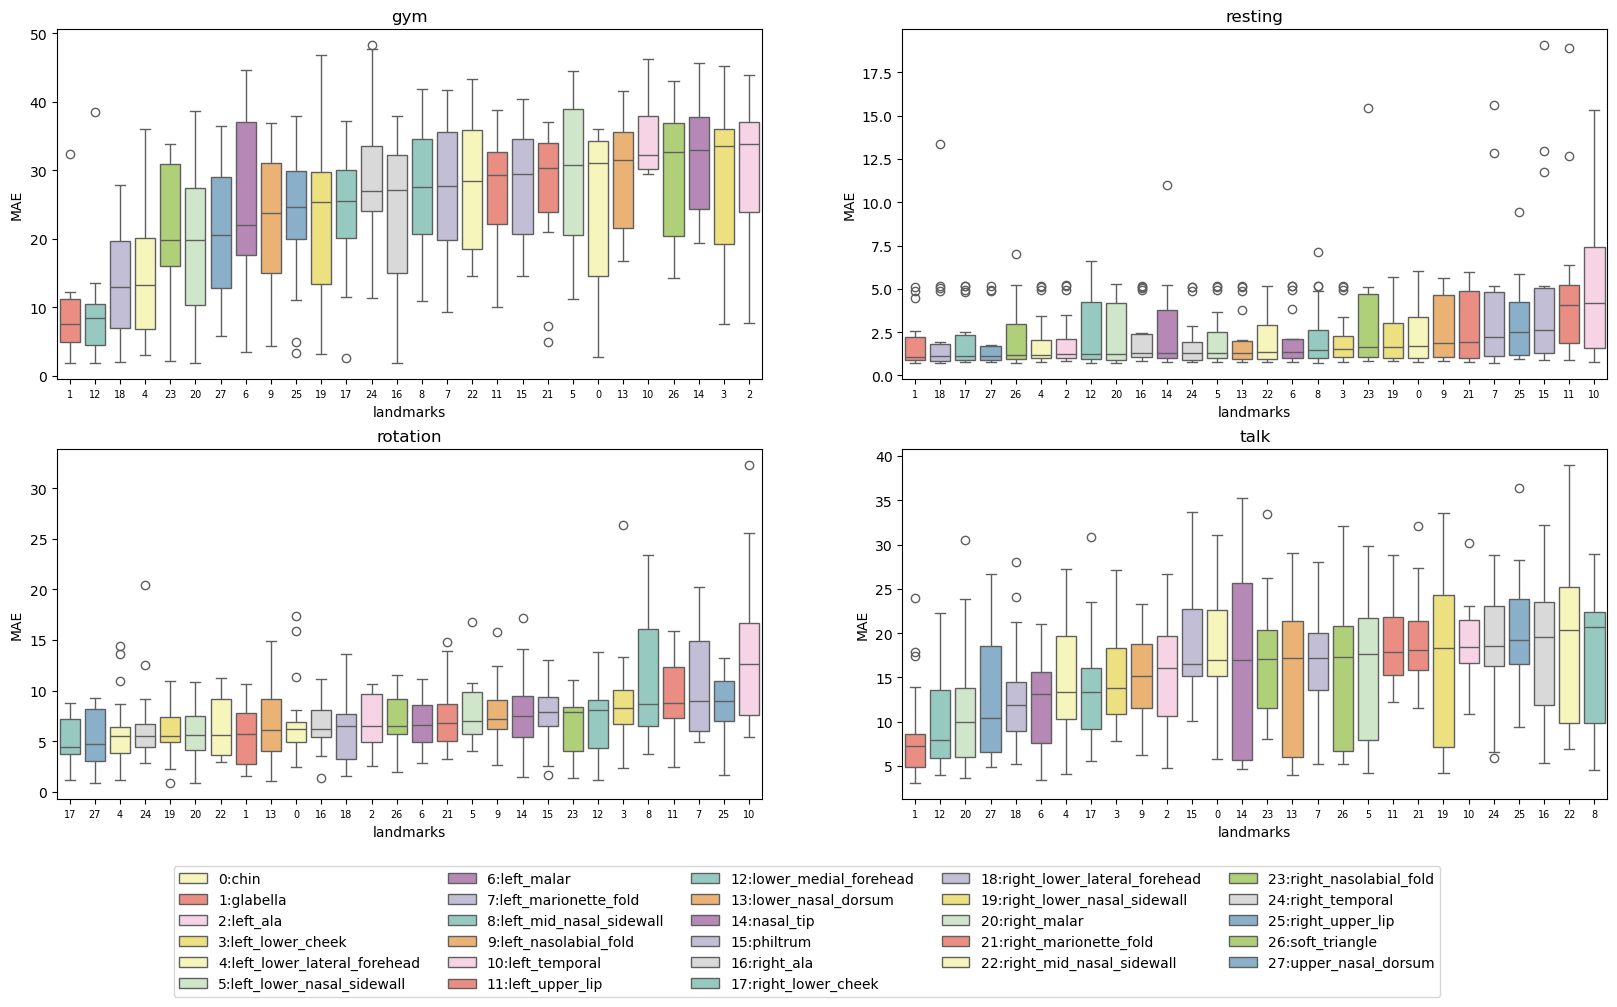

In [ ]:
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
landmarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
landmarks_mapping = dict(zip(landmarks_mapping['landmarks'].values, landmarks_mapping['landmarks_id'].values))

fig, axs = plt.subplots(2,2, figsize=(20,10))
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   old_labels = [item.get_text().replace(' ', '_')  for item in box.get_xticklabels()]
   new_labels = [landmarks_mapping[label] for label in old_labels]
   box.set_xticks(range(len(new_labels)))
   box.set_xticklabels(new_labels,rotation=0, fontsize=7)
   box.set(title=videos[i])
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles = [None] * len(df['landmarks_id'].unique())
labels = [None] * len(df['landmarks_id'].unique())
for (handle_label) in handles_labels:
    for i,(h,l) in enumerate(zip(*handle_label)):
        if  handles[landmarks_mapping[l]] is None:
            handles[landmarks_mapping[l]] = h
            labels[landmarks_mapping[l]] = str(landmarks_mapping[l])+':'+l
fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.show()

## Landmarks in ROI by video setting

In [7]:
rois = constants.get_rois()

df_all = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')

# this part is only for ROI by video setting part
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: x[0])
df_all = df_all[~df_all['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: tuple([x]))
df_all = df_all.query("method == 'CHROM'")

print(df_all.dataset.unique(), df_all.landmarks.unique().size)
df_all.head(1)

['lgi_ppgi'] 8


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,CHROM,lgi_ppgi,0,alex_gym,[18.85158658158916],[10.145047075320512],[0.7553941615464782],[0.7195200625268386],[-2.5228200496543045],[87.462890625],"[1.0986328125, 1.8310546875, 2.9296875, 8.4228...",[3463.861328125],"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[54.5654296875, 54.931640625, 52.001953125, 57...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",242.309525,"(lower_medial_forehead,)",forehead


### Forehead

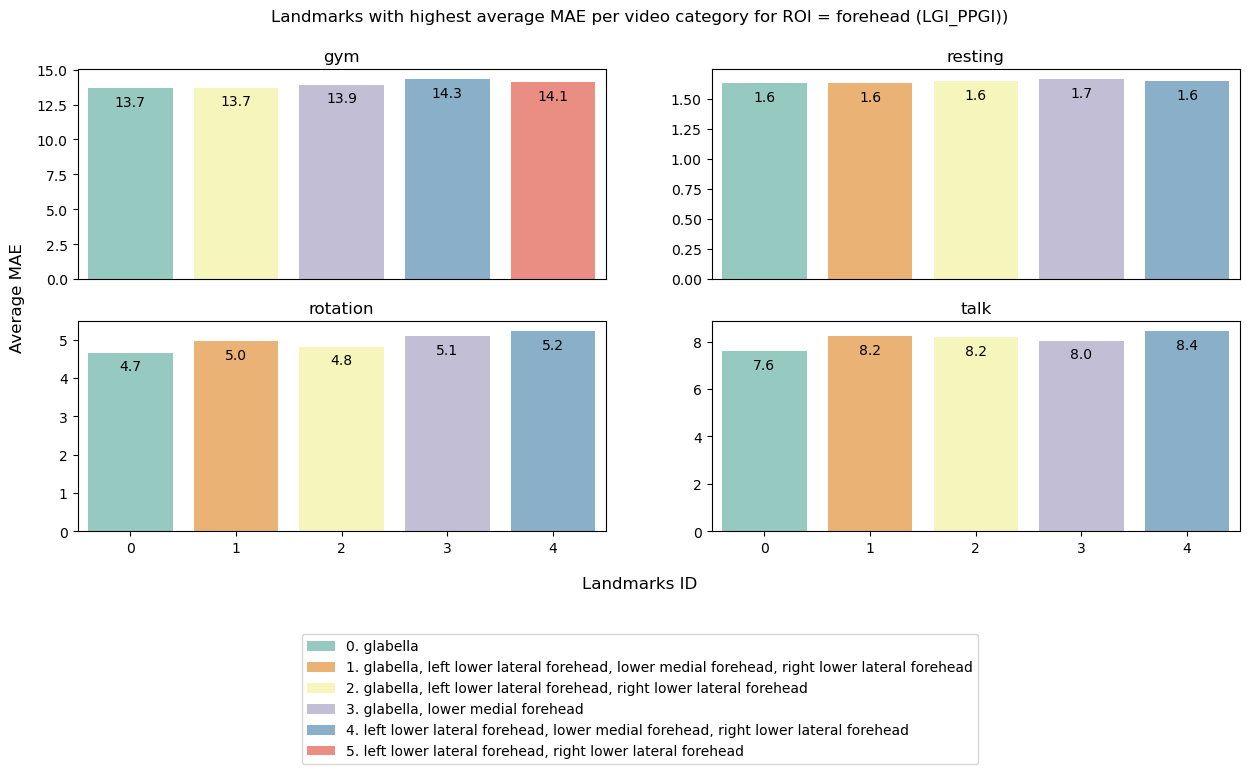

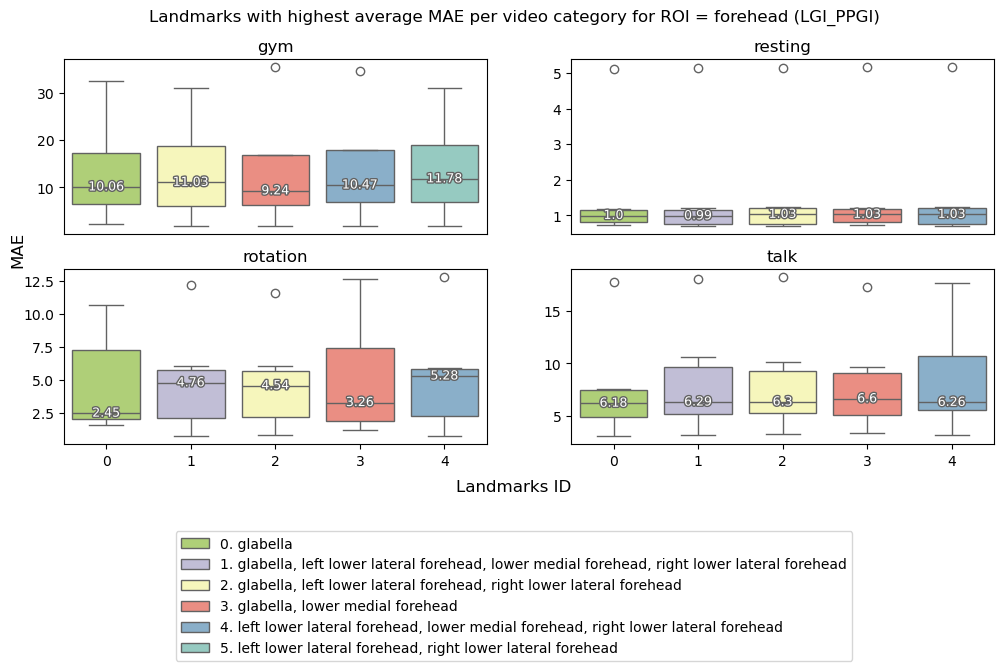

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
128,CHROM,lgi_ppgi,harun_gym,"(lower_medial_forehead,)",38.528084,[46.33282551720361],[-0.09547763518838541],gym,15.008310
10,cupy_CHROM,lgi_ppgi,cpi_talk,"(left_lower_lateral_forehead, right_lower_late...",18.423089,[20.58029952542592],[0.054792670545679434],talk,9.098909
130,CHROM,lgi_ppgi,harun_rotation,"(lower_medial_forehead,)",13.811353,[19.756263650222348],[0.32196647549603136],rotation,6.842426
125,CHROM,lgi_ppgi,felix_resting,"(lower_medial_forehead,)",5.168046,[5.651127537134995],[-0.12108440018547151],resting,1.892529


In [8]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, None, size=[1100,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Cheeks

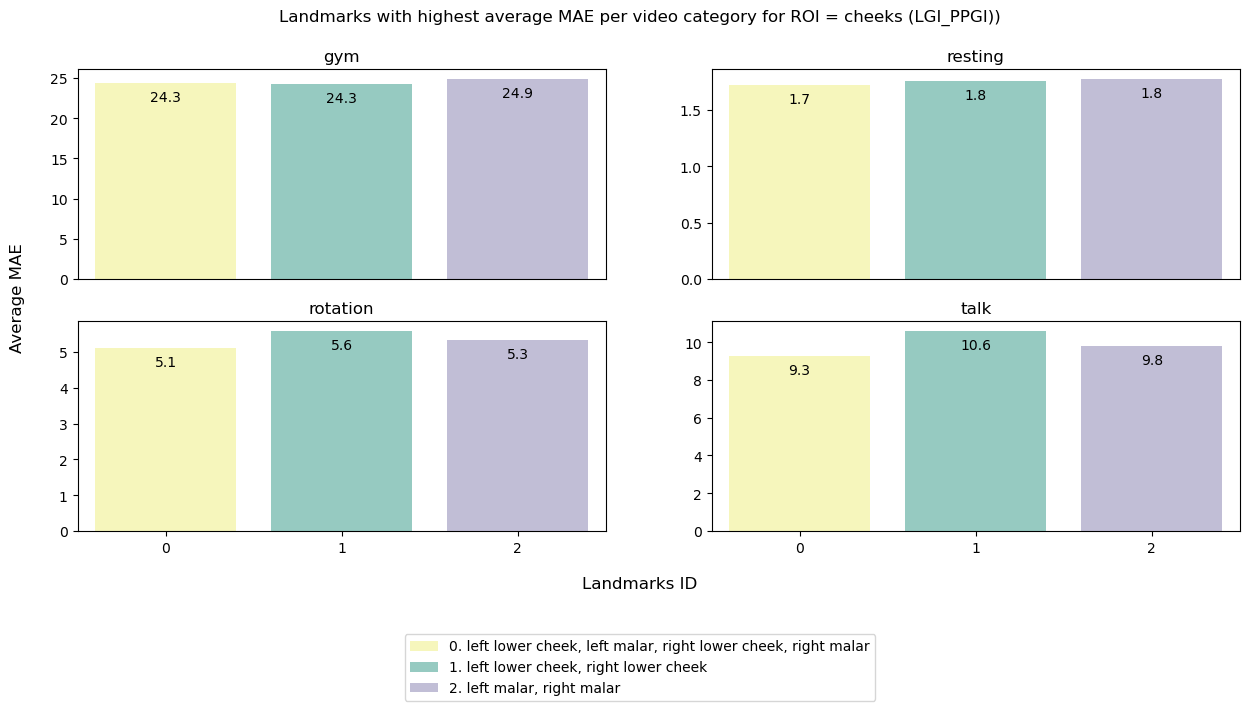

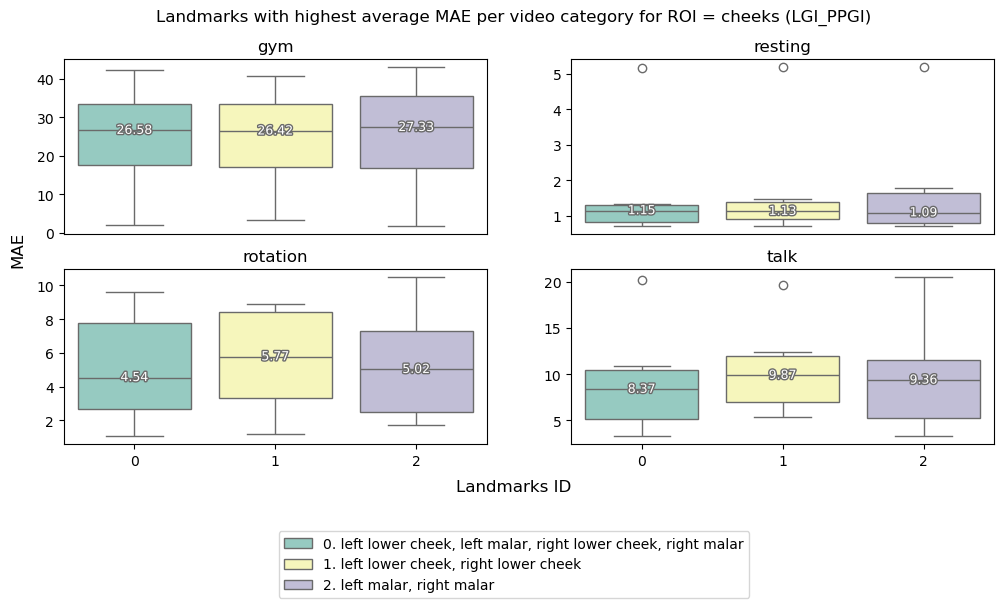

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
62,cupy_CHROM,lgi_ppgi,harun_gym,"(left_malar, right_malar)",42.988406,[48.636273338497894],[-0.18886429496357304],gym,24.859581
54,cupy_CHROM,lgi_ppgi,cpi_talk,"(left_malar, right_malar)",20.491066,[22.81844853166723],[-0.2920563989806595],talk,9.804225
64,cupy_CHROM,lgi_ppgi,harun_rotation,"(left_malar, right_malar)",10.487398,[16.605842641588413],[0.09116715821148498],rotation,5.336010
59,cupy_CHROM,lgi_ppgi,felix_resting,"(left_malar, right_malar)",5.185485,[5.716188520045998],[-0.25630836913625593],resting,1.770368


In [10]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Jaw

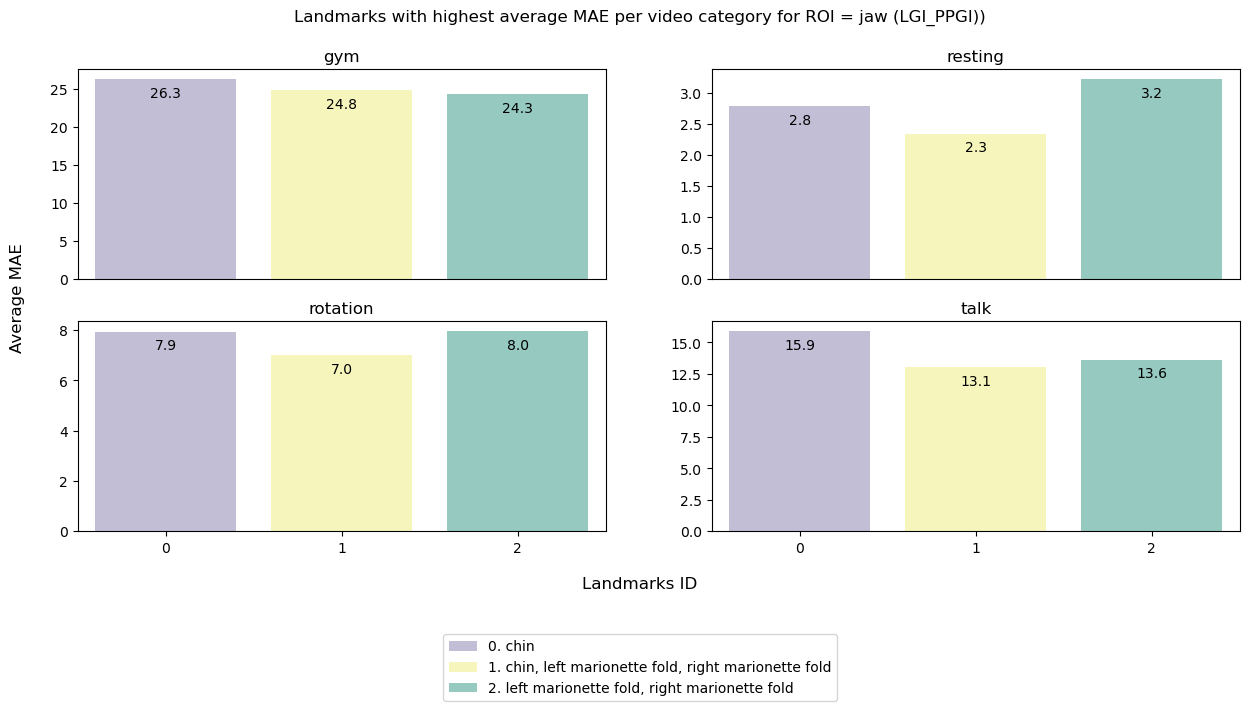

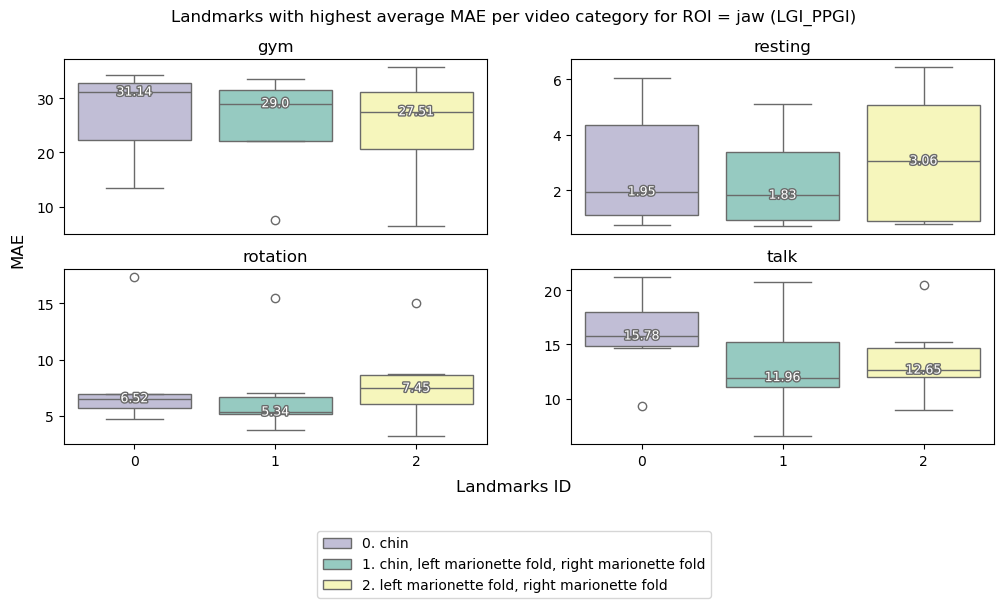

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
40,cupy_CHROM,lgi_ppgi,harun_gym,"(left_marionette_fold, right_marionette_fold)",35.770439,[42.84291082362478],[-0.20902615648971937],gym,24.298186
54,CHROM,lgi_ppgi,cpi_talk,"(chin,)",21.203336,[23.617578886040153],[-0.0006737194256982264],talk,15.909625
63,CHROM,lgi_ppgi,harun_rotation,"(chin,)",17.331427,[22.095580961347945],[0.36432491022830943],rotation,7.938552
41,cupy_CHROM,lgi_ppgi,harun_resting,"(left_marionette_fold, right_marionette_fold)",6.441528,[11.93973096626907],[0.2915701910670221],resting,3.217260


In [11]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Mustache

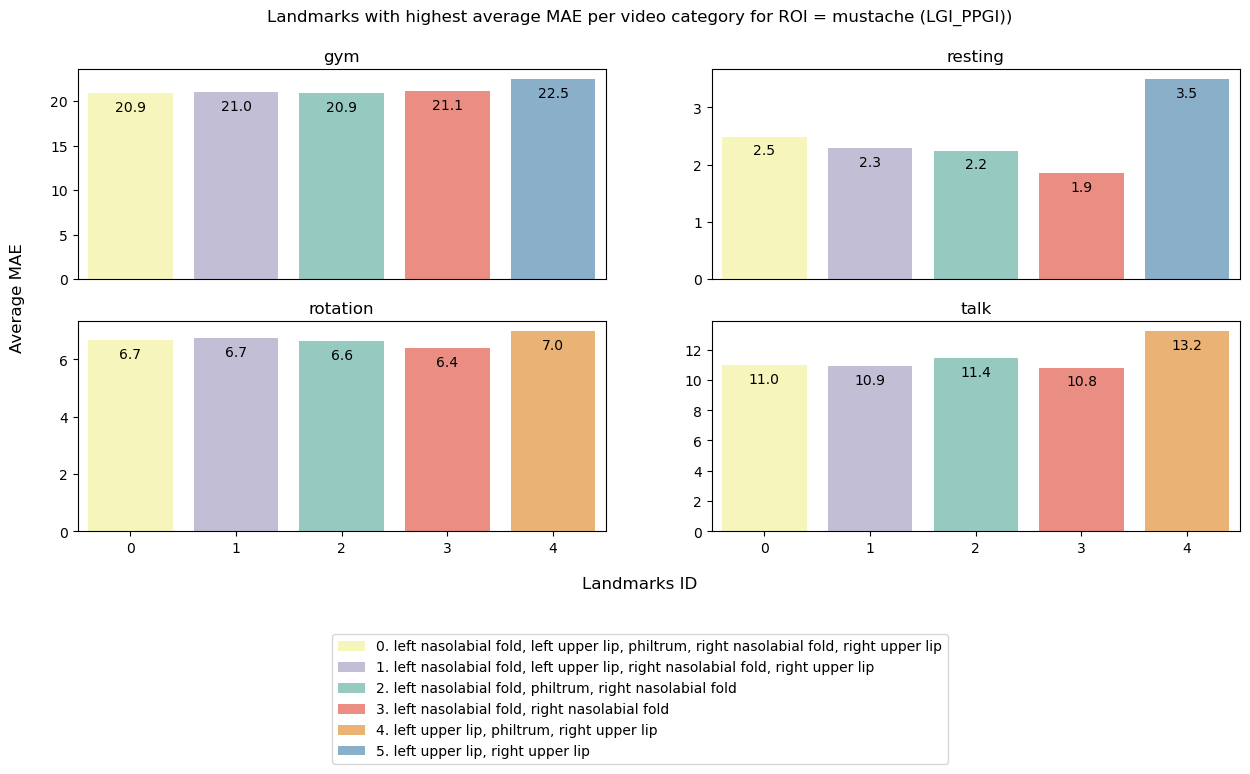

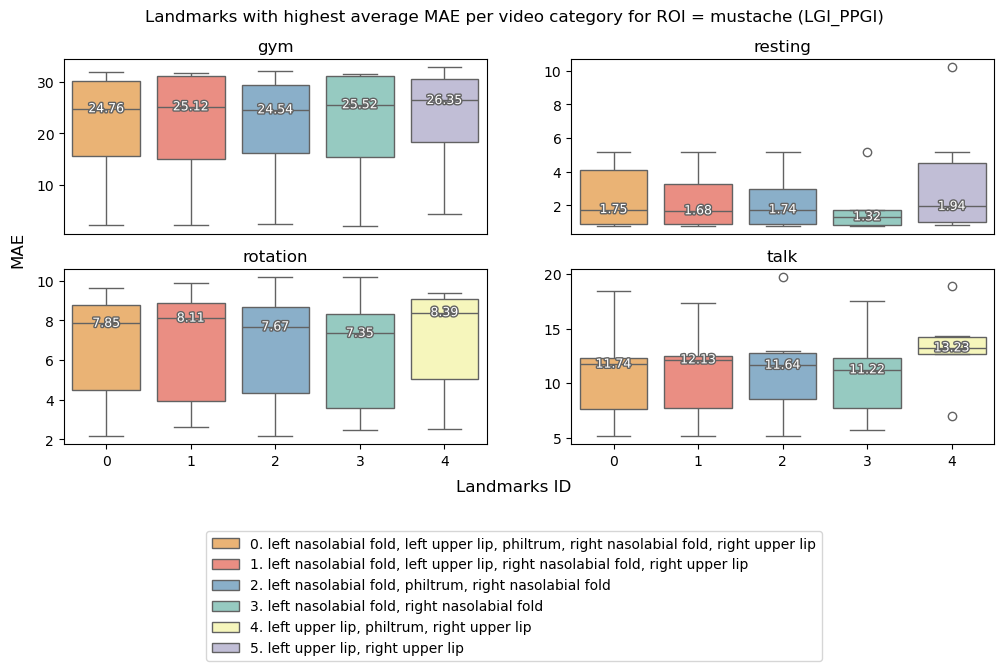

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
132,CHROM,lgi_ppgi,alex_gym,"(philtrum,)",37.787700,[44.869430341628345],[0.03239095127312617],gym,28.278779
142,CHROM,lgi_ppgi,cpi_talk,"(philtrum,)",24.565456,[27.87259139705927],[-0.3501828958002106],talk,17.016830
144,CHROM,lgi_ppgi,david_resting,"(philtrum,)",19.066595,[30.68056262524544],[0.3161698063234311],resting,5.327971
145,CHROM,lgi_ppgi,david_rotation,"(philtrum,)",10.928760,[16.327019567715162],[0.3614178657627971],rotation,7.392440


In [13]:
roi = 'mustache'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

In [27]:
# fig, ax = plt.subplots(figsize=(6, 4))
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()

## ROI combination

In [14]:
df_combine = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')

df1, fig, ax = plot_bubble_roi(df_combine, metric, dataset_name, roi, fig, ax, title=f'MAE vs Time requirement for different ROI combinations ({dataset_name})',size=[800,400])
fig.show()

# MRI-NIRP

Reding  ../results/test_landmarks/h5/MR_NIRP/MR_NIRP_each_landmark.h5


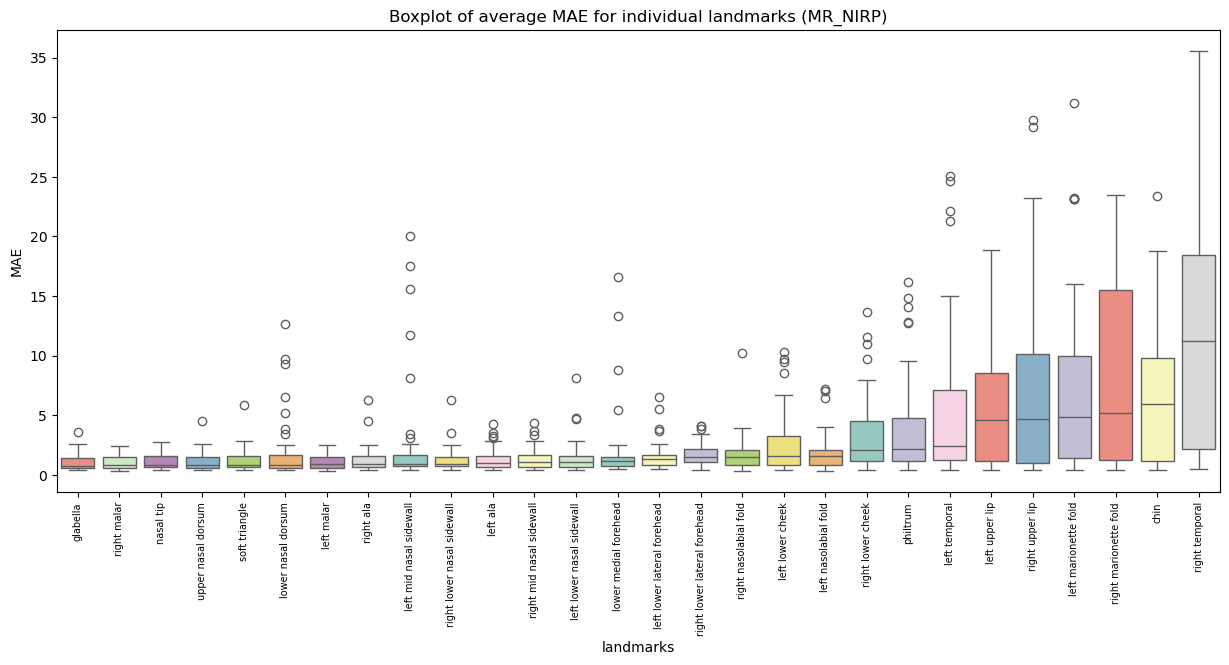

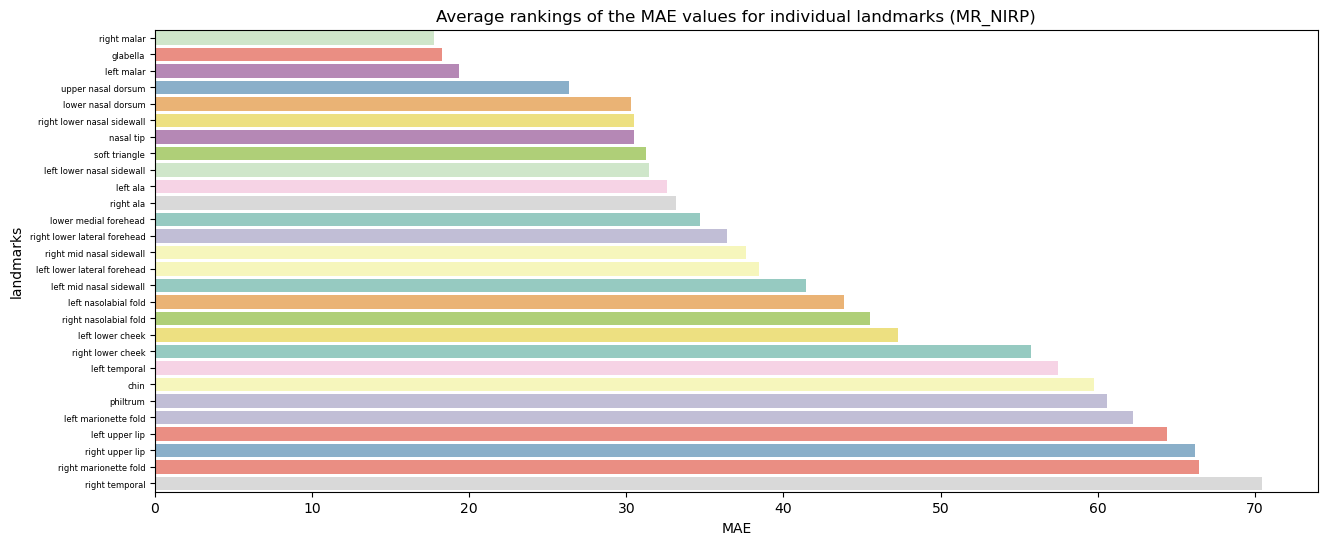

In [18]:
import pyVHR.analysis.pipelineLandmarks as custom_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = 'MR_NIRP'
path_results = f"../results/test_landmarks/h5/{dataset_name}/" # general path for cfg# general path for data
# path_results = f"../results/test_landmarks/{dataset_name}/" # general path for cfg# general path for data

filenameH5 = path_results + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)
df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(15,6))
_, ax2 = plt.subplots(1,1, figsize=(15,6))
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

In [19]:
# Worst performing video on each video setting
df.sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,video,person
900,CHROM,mr_nirp_temple,0,Subject1_motion_940,[44.78161380958853],35.557988,[-0.131917808071229],[-0.01287816731319924],[-3.9579663605525575],[108.146484375],"[25.927734375, 43.505859375, 35.15625, 35.5957...",[2040.216796875],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[76.025390625, 101.953125, 125.244140625, 110....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",44.461909,right_temporal,motion,Subject1
903,CHROM,mr_nirp_temple,1,Subject1_still_940,[38.23197298542965],31.427098,[0.06753217735276465],[0.005632089607448161],[-3.6937950828199297],[96.357421875],"[27.685546875, 31.640625, 25.927734375, 37.792...",[5231.517578125],"[76.0, 76.5, 77.0, 76.5, 76.0, 76.0, 76.0, 76....","[104.58984375, 119.970703125, 92.28515625, 101...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",122.909785,right_temporal,still,Subject1


In [20]:
# With glabella and CHROM the results should be ok, lets look at the worst score
df.query("landmarks == 'glabella'").query('method == "CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,video,person
165,CHROM,mr_nirp_forehead,10,Subject6_still_940,[3.5794018132565366],2.484396,[0.29531494630742383],[0.21339942852411273],[nan],[10.62890625],"[0.439453125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",[254.39648437499994],"[45.5, 47.5, 54.0, 54.5, 55.0, 55.0, 55.499999...","[54.4921875, 54.4921875, 54.4921875, 54.492187...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",153.605986,glabella,still,Subject6
153,CHROM,mr_nirp_forehead,6,Subject4_motion_940,[2.4036987342950735],1.438802,[0.8491332262445875],[0.8473594672707601],[7.184540270655243],[8.158203125],"[0.0, 0.87890625, 0.439453125, 0.0, 0.0, 0.878...",[89.70117187500004],"[76.0, 75.5, 74.0, 72.5, 70.0, 66.0, 62.500000...","[70.3125, 65.478515625, 61.962890625, 61.52343...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",42.379694,glabella,motion,Subject4


## Individual landmarks by video setting

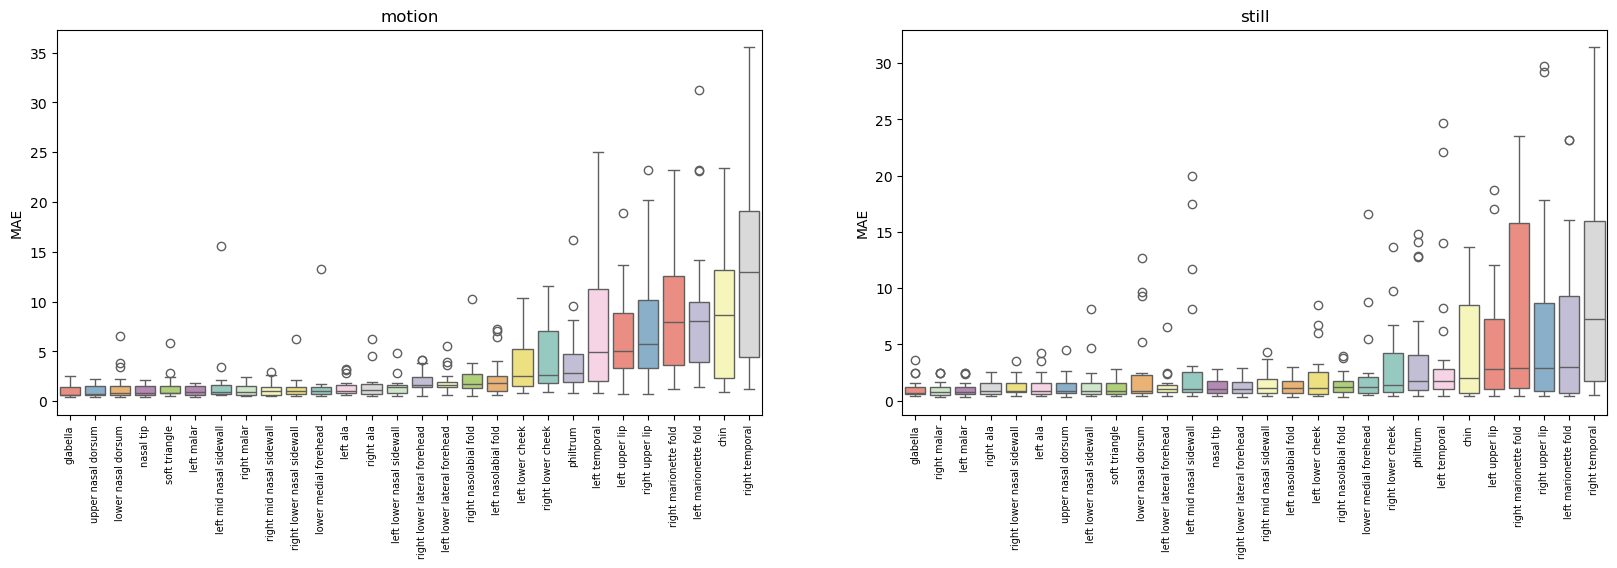

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

## Landmarks in RIO by video setting

In [24]:
# df_all = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')
# df_all['ROI'] = df_all['dataset'].apply(lambda x: x.split('_')[2])
# df_all['dataset'] = df_all['dataset'].apply(lambda x: '_'.join(x.split('_')[:2]))
# print(df_all.ROI.unique(), df_all.landmarks.unique().size)
# df_all.tail(2)
df_all.to_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5', key='df')

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_23360\2571175559.py:6: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['method', 'dataset', 'videoFilename', 'RMSE', 'MAE', 'PCC', 'CCC',
       'SNR', 'MAX', 'MAD', 'DTW', 'bpmGT', 'bpmES', 'timeGT', 'timeES',
       'landmarks', 'ROI'],
      dtype='object')]




In [36]:
df_all = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')

# this part is only for ROI by video setting part
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: x[0])
df_all = df_all[~df_all['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: tuple([x]))
df_all = df_all.query("method == 'CHROM'")
df_all = df_all.reset_index(drop=True)
# TODO save the file like this once i zg functions as well
print(df_all.landmarks.unique().size)
df_all.head(1)

8


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks
0,CHROM,mr_nirp_forehead,0,Subject1_motion_940,[1.9098900887358645],[1.0337082435344827],[0.8147077415848941],[0.7991721563067217],[0.5757400806559699],[8.640625],"[1.318359375, 0.439453125, 0.87890625, 0.87890...",[63.208984375],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[72.509765625, 75.5859375, 77.34375, 78.222656...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",51.750714,"(lower_medial_forehead,)"


In [38]:
roi = 'mustache'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df['ROI'] = df['dataset'].apply(lambda x: x.split('_')[2])
df['dataset'] = df['dataset'].apply(lambda x: '_'.join(x.split('_')[:2]))
print(df.ROI.unique(), df.landmarks.unique().size)
df.head(1)
x = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')
df = pd.concat([df, x], axis=0)
print(df.ROI.unique(), df.landmarks.unique().size)
df.head()
df.to_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')

['mustache'] 6
['mustache' 'jaw' 'cheeks' 'forehead'] 16


C:\Users\erolland\AppData\Local\Temp\3\ipykernel_23360\606345393.py:11: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['method', 'dataset', 'videoFilename', 'RMSE', 'MAE', 'PCC', 'CCC',
       'SNR', 'MAX', 'DTW', 'MAD', 'bpmGT', 'bpmES', 'timeGT', 'timeES',
       'landmarks', 'ROI'],
      dtype='object')]




In [40]:
rois = constants.get_rois()

df_all = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')

# this part is only for ROI by video setting part
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: x[0])
df_all = df_all[~df_all['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_all['landmarks'] = df_all['landmarks'].apply(lambda x: tuple([x]))
df_all = df_all.query("method == 'CHROM'")

print(df_all.dataset.unique(), df_all.ROI.unique(), df_all.landmarks.unique().size)
df_all.head(1)

['mr_nirp'] ['forehead' 'nose' 'mustache' 'jaw'] 8


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,CHROM,mr_nirp,0,Subject1_motion_940,[1.9098900887358645],[1.0337082435344827],[0.8147077415848941],[0.7991721563067217],[0.5757400806559699],[8.640625],"[1.318359375, 0.439453125, 0.87890625, 0.87890...",[63.208984375],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[72.509765625, 75.5859375, 77.34375, 78.222656...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",51.750714,"(lower_medial_forehead,)",forehead


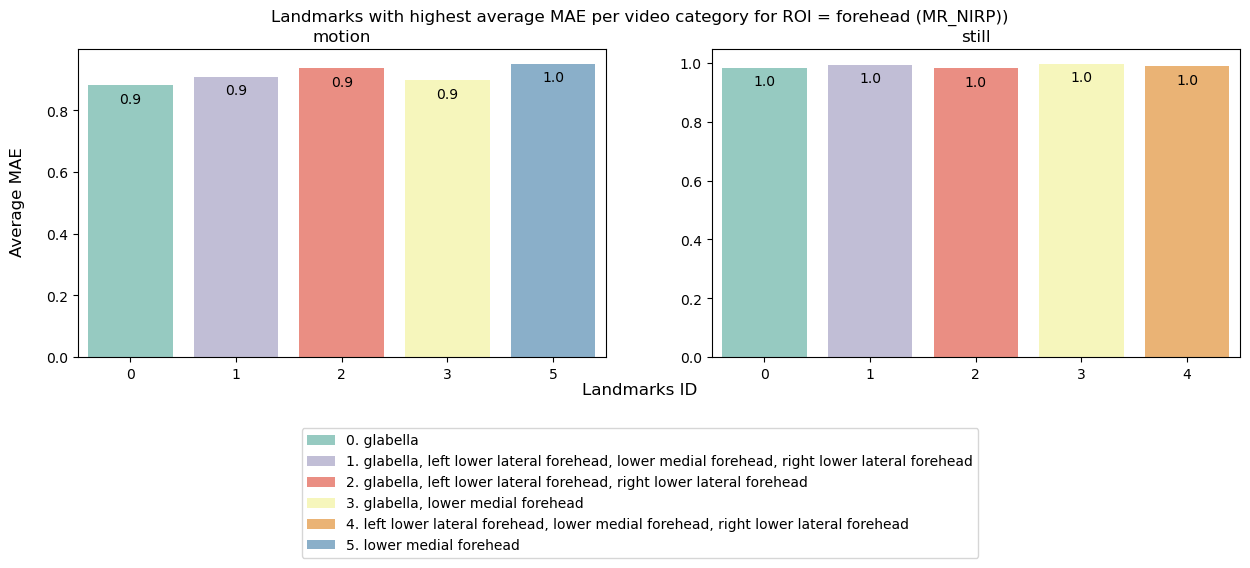

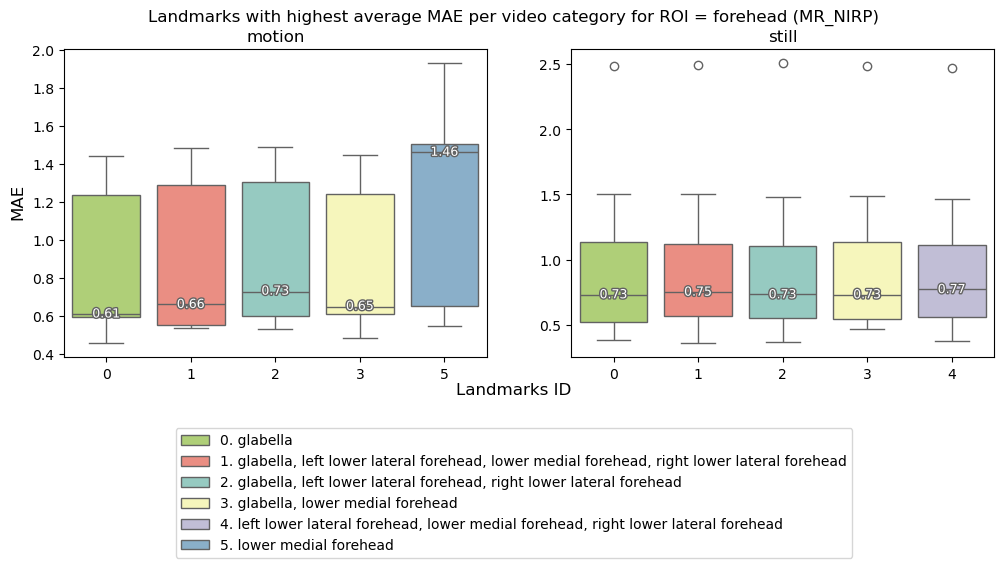

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
10,cupy_CHROM,mr_nirp,Subject6_still_940,"(glabella, left_lower_lateral_forehead, right_...",2.506794,[3.5879640860807016],[0.2963296510886998],still,0.982475
73,cupy_CHROM,mr_nirp,Subject8_motion_940,"(left_lower_lateral_forehead, right_lower_late...",1.927919,[5.400910058366144],[0.599633410423806],motion,1.178129


In [42]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

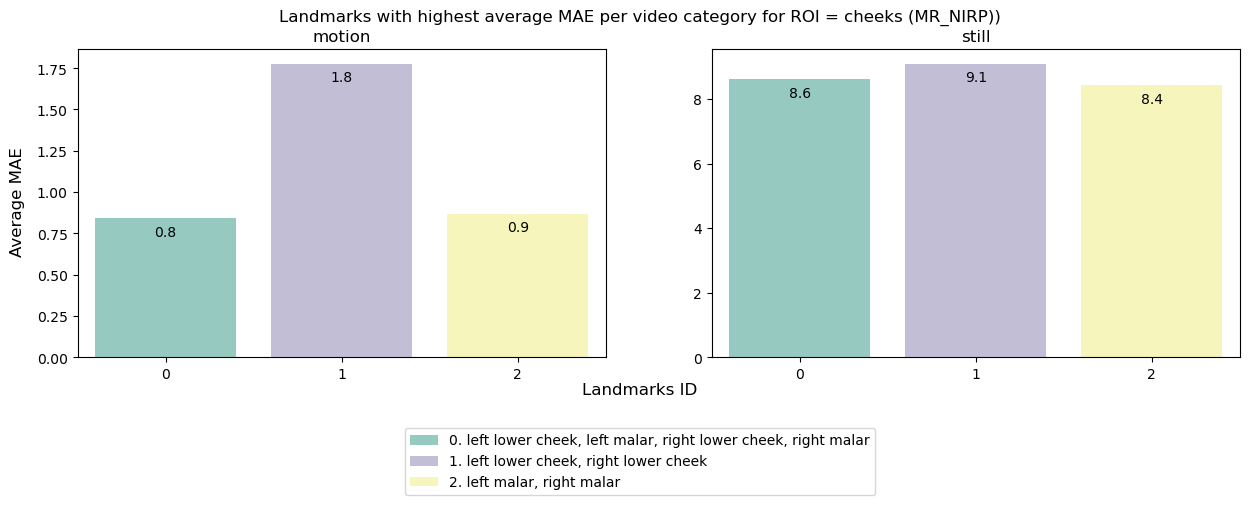

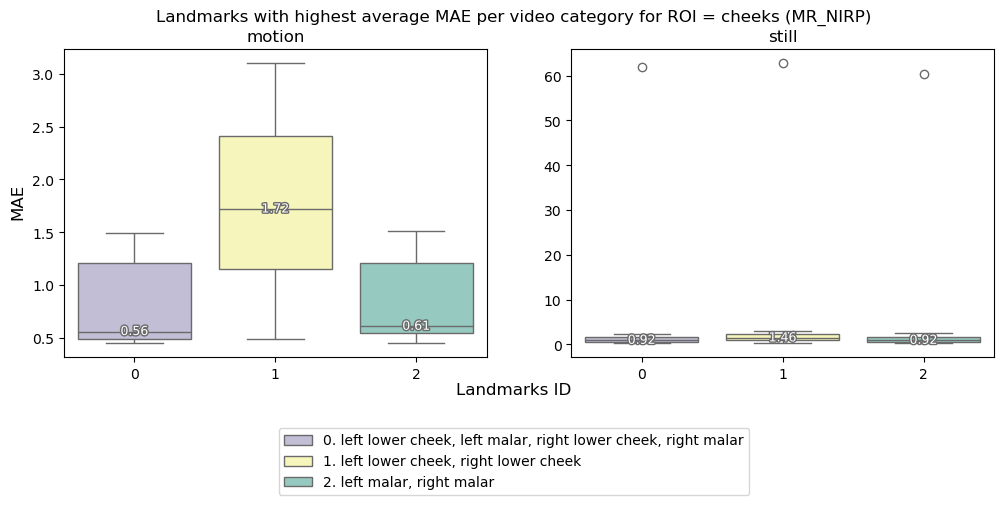

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
18,cupy_CHROM,mr_nirp,Subject2_still_940,"(left_lower_cheek, right_lower_cheek)",62.785118,[65.19479363459641],[0.16176320852589116],still,9.093183
15,cupy_CHROM,mr_nirp,Subject1_motion_940,"(left_lower_cheek, right_lower_cheek)",3.101529,[5.3269160161723486],[0.3773749763666305],motion,1.776647


In [44]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[800,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

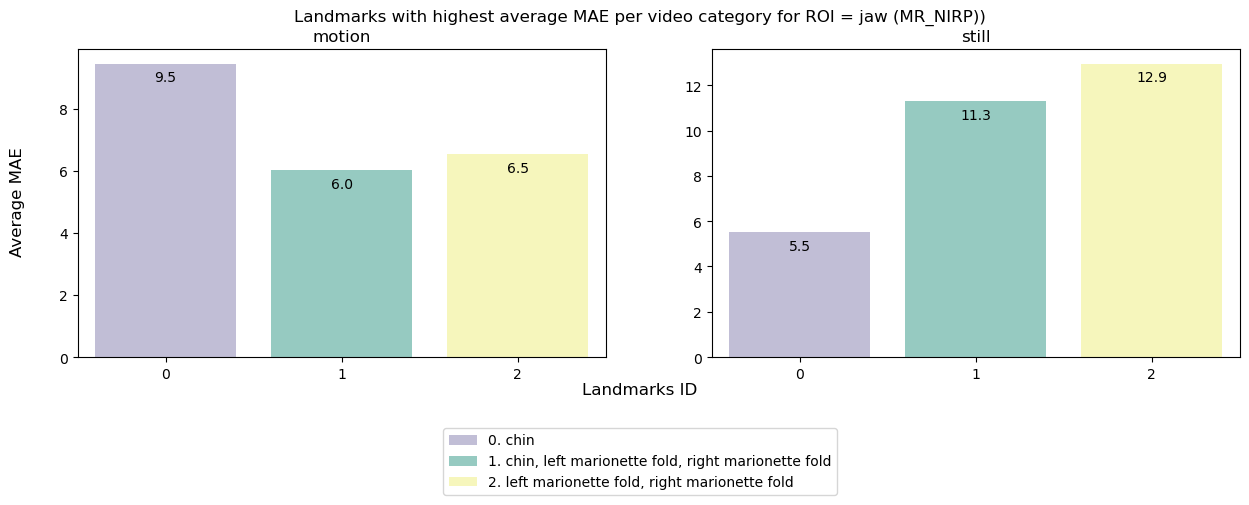

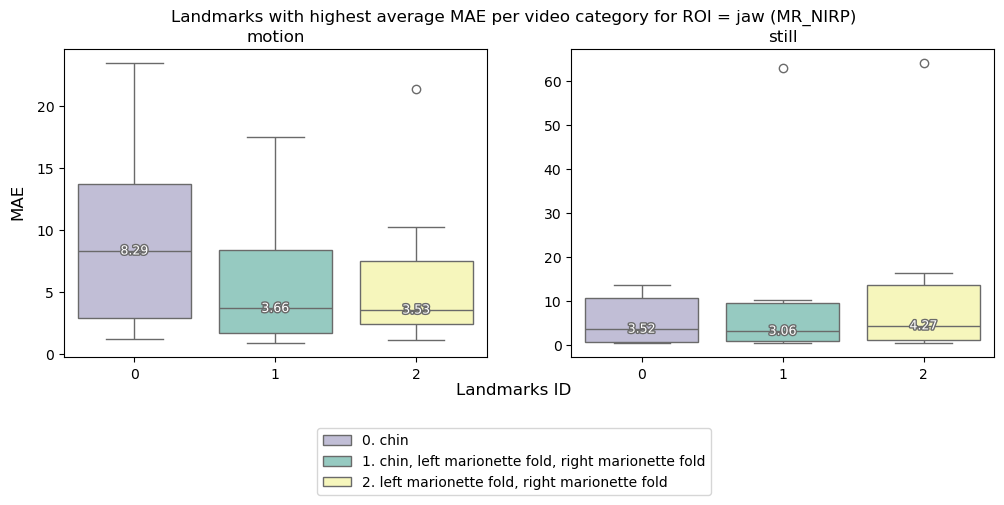

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
18,cupy_CHROM,mr_nirp,Subject2_still_940,"(left_marionette_fold, right_marionette_fold)",63.984413,[67.47299296142866],[0.02139655270178253],still,12.948514
34,CHROM,mr_nirp,Subject3_motion_940,"(chin,)",23.429798,[29.9781966661305],[0.022167782833318432],motion,9.450695


In [45]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[800,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

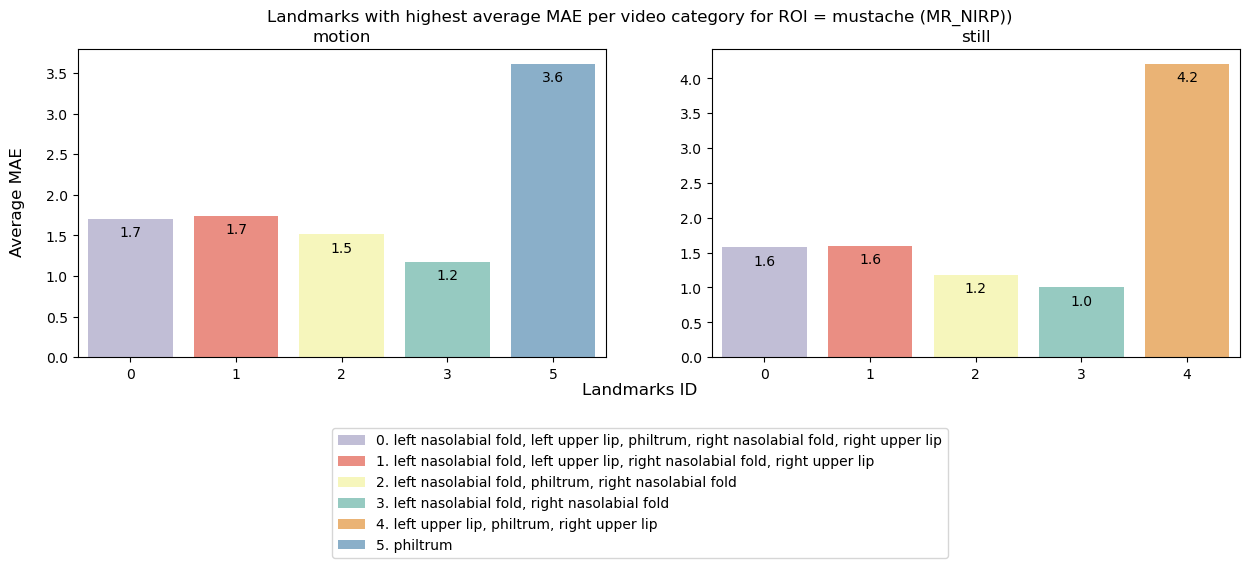

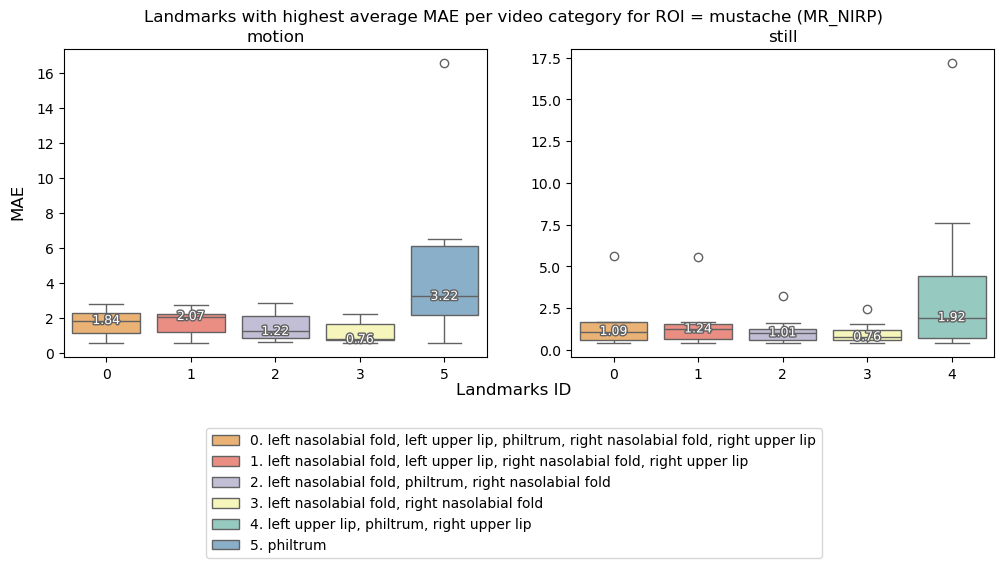

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
70,cupy_CHROM,mr_nirp,Subject6_still_940,"(left_upper_lip, right_upper_lip)",20.042181,[26.731092169685606],[-0.016408615716110582],still,4.783056
69,cupy_CHROM,mr_nirp,Subject6_motion_940,"(left_upper_lip, right_upper_lip)",16.534493,[23.094319189022393],[-0.298000942439215],motion,5.255362


In [47]:
roi = 'mustache'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_all.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, size=[1000,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

## Combine ROIs

In [53]:
df_combine = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')

df1, fig, ax = plot_bubble_roi(df_combine, metric, dataset_name, roi, fig, ax, size=[800,400])
fig.show()

In [55]:
videos = df1.video.unique()
df_video = df1.loc[df1['video'] == videos[0]].reset_index(drop=True).copy()
_, fig, ax = plot_bubble_roi(df_video, metric, dataset_name, roi, fig, ax, size=[800,300])
fig.update_layout(title=f"MAE vs Time requirement for each landmark ({dataset_name.upper()}) ({videos[0]})")
fig.show()
df_video = df1.loc[df1['video'] == videos[1]].reset_index(drop=True).copy()
_, fig, ax = plot_bubble_roi(df_video, metric, dataset_name, roi, fig, ax, size=[800,300])
fig.update_layout(title=f"MAE vs Time requirement for each landmark ({dataset_name.upper()}) ({videos[1]})")
fig.show()

# Combine ROI

In [155]:
datasets = ['MR_NIRP', 'LGI_PPGI']
df = pd.DataFrame()
for dataset_name in datasets:
    df = pd.concat([df, pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')])
df = df.sort_values(by='landmarks').reset_index(drop=True)
df['ROI'] = df['dataset'].apply(lambda x: tuple(x.split('_')[2:]))
print(df.shape, df.landmarks.unique().size, df.dataset.unique().size)
print(df.dataset.unique())
df.head(2)

(267, 19) 6 12
['lgi_ppgi_cheeks_mustache' 'mr_nirp_cheeks_mustache'
 'lgi_ppgi_jaw_cheeks' 'mr_nirp_jaw_cheeks' 'lgi_ppgi_jaw_mustache'
 'mr_nirp_jaw_mustache' 'mr_nirp_forehead_cheeks'
 'lgi_ppgi_forehead_cheeks' 'mr_nirp_forehead_jaw' 'lgi_ppgi_forehead_jaw'
 'lgi_ppgi_forehead_mustache' 'mr_nirp_forehead_mustache']


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,cupy_CHROM,lgi_ppgi_cheeks_mustache,cpi,NaN,[4.0057003053124145],[2.0903253424657535],[0.32871854696423014],[0.26534213364315673],[1.3716328315985427],[14.1953125],"[0.3662109375, 0.732421875, 0.732421875, 0.732...",[152.29492187499997],"[54.5, 55.0, 56.5, 57.5, 58.0, 58.5, 58.5, 58....","[58.2275390625, 58.59375, 57.861328125, 57.861...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",42.124689,"(left_malar, right_malar, left_lower_cheek, ri...","(cheeks, mustache)"
1,cupy_CHROM,mr_nirp_cheeks_mustache,Subject8_still_940-001,NaN,[2.2701440922875262],[1.5151169617052023],[0.7423549657701388],[0.7224840974590908],[3.0936887759090848],[8.46484375],"[1.318359375, 0.87890625, 0.87890625, 0.878906...",[225.38671875],"[78.0, 76.0, 69.5, 67.5, 66.0, 65.5, 66.5, 68....","[66.357421875, 65.91796875, 66.796875, 68.5546...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",122.031217,"(left_malar, right_malar, left_lower_cheek, ri...","(cheeks, mustache)"


In [106]:
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, title='Average MAE vs Time requirement for different ROI combinations (LGI-PPGI,MR-NIRP)',size=[1000,400])
fig.show()

# Combine landmarks

In [121]:
datasets = ['MR_NIRP', 'LGI_PPGI']
df_each = pd.DataFrame()
for dataset_name in datasets:
    df_each = pd.concat([df_each, pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')])
# this part is only for ROI by video setting part
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: x[0])
df_each = df_each[~df_each['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: tuple([x]))
df_each = df_each.query("method == 'CHROM'")
df_each = df_each.reset_index(drop=True)

print(df_each.shape, df_each.landmarks.unique().size, df_each.dataset.unique().size)
print(df_each.dataset.unique())
df_each.head(2)

(295, 18) 8 8
['mr_nirp_forehead' 'mr_nirp_nose' 'mr_nirp_mustache' 'mr_nirp_jaw'
 'lgi_ppgi_forehead' 'lgi_ppgi_nose' 'lgi_ppgi_mustache' 'lgi_ppgi_jaw']


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks
0,CHROM,mr_nirp_forehead,0,Subject1_motion_940,[1.9098900887358645],[1.0337082435344827],[0.8147077415848941],[0.7991721563067217],[0.5757400806559699],[8.640625],"[1.318359375, 0.439453125, 0.87890625, 0.87890...",[63.208984375],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[72.509765625, 75.5859375, 77.34375, 78.222656...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",51.750714,"(lower_medial_forehead,)"
1,CHROM,mr_nirp_forehead,1,Subject1_still_940,[2.003125819765999],[1.1412154796511629],[0.7398285061419014],[0.7312979777513188],[0.686383985416479],[9.869140625],"[0.87890625, 0.87890625, 0.0, 2.197265625, 1.7...",[164.45703125],"[76.0, 76.5, 77.0, 76.5, 76.0, 76.0, 76.0, 76....","[76.904296875, 76.904296875, 75.5859375, 74.70...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",145.926259,"(lower_medial_forehead,)"


In [123]:
rois = ['forehead','jaw','cheeks','mustache']
df_all = df_each.copy()
for dataset in datasets:
    for roi in rois:
        df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
        df_all = pd.concat([df_all,df])
df_all['ROI'] = df_all['dataset'].apply(lambda x: x.split('_')[2]) # only one ROI (ex: ROI = jaw)
df_all = df_all.sort_values(by='landmarks').reset_index(drop=True)
print(df_all.shape, df_all.landmarks.unique().size, df_all.dataset.unique().size, df_all.videoFilename.unique().size,)
print(df_all.dataset.unique())
df_all.head(2)

(999, 19) 24 9 37
['lgi_ppgi_jaw' 'mr_nirp_jaw' 'lgi_ppgi_forehead' 'mr_nirp_forehead'
 'lgi_ppgi_cheeks' 'lgi_ppgi_mustache' 'lgi_ppgi_nose' 'mr_nirp_nose'
 'mr_nirp_mustache']


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,CHROM,lgi_ppgi_jaw,3,alex_talk,[21.992339627501917],[14.64937999636628],[0.39631102045925015],[0.11618012239522507],[-2.923496532887437],[68.8154296875],"[29.296875, 28.564453125, 11.71875, 4.02832031...",[1119.9365234375],"[82.0, 80.0, 72.5, 72.5, 73.5, 75.0, 76.5, 77....","[81.298828125, 81.298828125, 83.1298828125, 85...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",47.099755,"(chin,)",jaw
1,CHROM,lgi_ppgi_jaw,22,harun_rotation,[22.095580961347945],[17.331426711309526],[0.36432491022830943],[0.07737408852541366],[-3.799572494084252],[54.927734375],"[34.7900390625, 25.634765625, 27.099609375, 33...",[941.0947265625],"[87.5, 88.5, 90.5, 91.5, 90.5, 88.0, 85.0, 82....","[95.947265625, 98.14453125, 88.623046875, 113....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",35.888608,"(chin,)",jaw


In [147]:
roi = rois[0]
df = df_all.query(f'ROI == "{roi}"').copy()
df = df.reset_index(drop=True)
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, 
                                title=f'Average MAE vs Time requirement for different landmarks in ROI {roi} ({", ".join(datasets)})', size=[1200,400])
fig.show()

In [148]:
roi = rois[1]
df = df_all.query(f'ROI == "{roi}"').copy()
df = df.reset_index(drop=True)
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, 
                                title=f'Average MAE vs Time requirement for different landmarks in ROI {roi} ({", ".join(datasets)})', size=[850,400])
fig.show()

In [149]:
roi = rois[2]
df = df_all.query(f'ROI == "{roi}"').copy()
df = df.reset_index(drop=True)
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, 
                                title=f'Average MAE vs Time requirement for different landmarks in ROI {roi} ({", ".join(datasets)})', size=[850,400])
fig.show()

In [153]:
roi = rois[3]
df = df_all.query(f'ROI == "{roi}"').copy()
df = df.reset_index(drop=True)
df1, fig, ax = plot_bubble_roi(df, metric, dataset_name, roi, fig, ax, 
                                title=f'Average MAE vs Time requirement for different landmarks in ROI {roi} ({", ".join(datasets)})', size=[1200,400])
fig.show()